# CIFAR 10 Image Classification

In this notebook, I am using the CIFAR 10 dataset to train a CNN model to classify images into one of 10 classes:
1. airplane
2. automobile
3. bird
4. cat
5. deer
6. dog
7. frog
8. horse
9. ship
10. truck

Link to the dataset: https://www.cs.toronto.edu/~kriz/cifar.html 

I will be training the model using pytorch.

In [1]:
import torch
from torchvision import datasets,transforms
from torch.utils.data import DataLoader,random_split
from matplotlib import pyplot
import numpy as np
from torch import nn
import torch.nn.functional as F
from torch import optim
import pandas as pd

### Load Dataset
We load the dataset using torchvision, and split it into train and test sets

#### Data Transform
In order to obtain better results we have to perform the following transforms:
1. Random Crop: 
2. Horizontal Flip: 
3. Normalization: 

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),  # converts to [0,1]
])

train_dataset = datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

In [3]:
classes = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

### Visualizing the Images
We visualize the first 5 images of the dataset, which are 32x32 colored images.

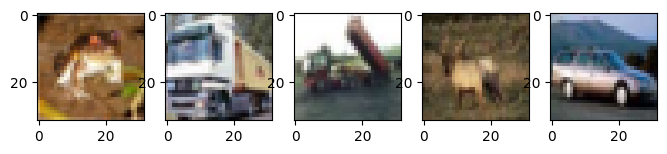

In [4]:
fig, axes = pyplot.subplots(1,5,figsize=(8,3))
for i in range(len(axes)):
    axes[i].imshow(train_dataset[i][0].permute(1, 2, 0), cmap="gray")

### Split into Validation Set
Creating a validation set in order to fine tune the model.

In [5]:
len(train_dataset),len(test_dataset)

(50000, 10000)

In [6]:
full_dataset = train_dataset  # e.g. CIFAR10(train=True)

# Split sizes
val_ratio = 0.1
val_size = int(len(full_dataset) * val_ratio)
train_size = len(full_dataset) - val_size

# Split
train_ds, val_ds = random_split(
    full_dataset,
    [train_size, val_size]
)

In [7]:
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### EDA

Checking for Class imbalance

In [8]:
labels = np.array([label for __, label in train_dataset])

In [9]:
np.bincount(labels)

array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000])

No class imbalance, train data has equal datapoints for each class

In [10]:
labels_val = np.array([label for __, label in test_dataset])
np.bincount(labels_val)

array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000])

### Defining base Model

In [11]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x): # creating view layer that reshapes image matrix     
    return x.view(-1, 3, 32, 32)

In [ ]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        # print(loss)
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        # print(losses,nums)
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums) # Average batch wise validation loss

        # Early Stopping
        if val_loss > best_val_loss:
            patience_counter += 1   
        print(epoch, val_loss)

In [14]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

In [22]:
summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Lambda-1            [-1, 3, 32, 32]               0
            Conv2d-2           [-1, 16, 16, 16]             448
              ReLU-3           [-1, 16, 16, 16]               0
            Conv2d-4             [-1, 16, 8, 8]           2,320
              ReLU-5             [-1, 16, 8, 8]               0
            Conv2d-6             [-1, 10, 4, 4]           1,450
              ReLU-7             [-1, 10, 4, 4]               0
         AvgPool2d-8             [-1, 10, 1, 1]               0
            Lambda-9                   [-1, 10]               0
Total params: 4,218
Trainable params: 4,218
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.10
Params size (MB): 0.02
Estimated Total Size (MB): 0.13
-----------------------------------------------

In [ ]:
lr = 0.1
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
loss_func = F.cross_entropy

fit(10, model, loss_func, opt, train_loader, val_loader)

0 1.9454066368103027
1 1.7650541831970215
2 1.6894147998809814
3 1.6395266544342042
4 1.6009808971405028
5 1.5641614751815796
6 1.5562296747207642
7 1.5112775846481323
8 1.4938481004714965
9 1.5074470615386963


In [28]:
model(train_dataset[0][0])

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], grad_fn=<ViewBackward0>)

In [26]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

def print_accuracy(model, train_loader, val_loader):
    accuracies = [accuracy(model(xb), yb) for xb, yb in train_loader]
    print("Train accuracy: ",sum(accuracies)/len(accuracies))
    accuracies = [accuracy(model(xb), yb) for xb, yb in val_loader]
    print("Validation Accuracy: ", sum(accuracies)/len(accuracies))

In [ ]:
print_accuracy(model, train_loader, val_loader)

tensor(0.4595)

Train accuracy and validation accuracy both low. So this might be underfitting.

### Fine Tuning Model Structure

In [19]:
model_tuned = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(2),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

In [20]:
from torchsummary import summary
summary(model_tuned,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Lambda-1            [-1, 3, 32, 32]               0
            Conv2d-2           [-1, 16, 16, 16]             448
              ReLU-3           [-1, 16, 16, 16]               0
            Conv2d-4             [-1, 16, 8, 8]           2,320
              ReLU-5             [-1, 16, 8, 8]               0
            Conv2d-6             [-1, 16, 4, 4]           2,320
              ReLU-7             [-1, 16, 4, 4]               0
            Conv2d-8             [-1, 10, 2, 2]           1,450
              ReLU-9             [-1, 10, 2, 2]               0
        AvgPool2d-10             [-1, 10, 1, 1]               0
           Lambda-11                   [-1, 10]               0
Total params: 6,538
Trainable params: 6,538
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/back

In [23]:
model_tuned(train_dataset[0][0])

tensor([[0.0516, 0.0000, 0.0547, 0.0030, 0.0000, 0.0852, 0.0819, 0.0423, 0.0022,
         0.0418]], grad_fn=<ViewBackward0>)

In [ ]:
lr = 0.01
opt_tuned = optim.SGD(model_tuned.parameters(), lr=lr, momentum=0.9)
loss_func = nn.CrossEntropyLoss(label_smoothing = 0.1)

fit(10, model_tuned, loss_func, opt_tuned, train_loader, val_loader)

0 1.620018039894104
1 1.6033308406829834
2 1.594695777130127
3 1.5915376642227173
4 1.5788115295410157
5 1.574930908203125
6 1.572695639038086
7 1.5665734727859497
8 1.5643423023223877
9 1.5669266250610352


In [29]:
print_accuracy(model_tuned, train_loader, val_loader)

Train accuracy:  tensor(0.5539)
Validation Accuracy:  tensor(0.5200)


### Sanity Check

Overfitting the CNN on 100 training samples. We expect a train accuracy of 100%

In [ ]:
# fit(50, model_tuned, loss_func, opt_tuned, train_loader, val_loader)

### Model evaluation

Confusion Matrix